In [1]:
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import copy

In [2]:
CHEAP = 100_000
EXPENSIVE = 350_000
SEED = 150
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
df = pd.read_csv("train_data.csv", sep=',')
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


In [4]:
#plt.hist(df["YearBuilt"])
#plt.show()
class_nr = 0
for i in range(df['YearBuilt'].min(), df['YearBuilt'].max(), 5):
    df["YearBuilt"].mask( (df['YearBuilt']>=i) & (df['YearBuilt'] < i+5), class_nr, inplace=True)
    class_nr += 1
df['YearBuilt'].describe()
#plt.hist(df["YearBuilt"])
#plt.show()

count    4124.000000
mean        4.558923
std         1.801223
min         0.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         7.000000
Name: YearBuilt, dtype: float64

In [5]:
df['SalePrice'].mask(df['SalePrice'] <= CHEAP, 0, inplace=True)
df['SalePrice'].mask((df['SalePrice'] > CHEAP) & (df['SalePrice'] <= EXPENSIVE), 1, inplace=True)
df['SalePrice'].mask(df['SalePrice'] > EXPENSIVE, 2, inplace=True)


categorical_columns = [
    'YearBuilt', 'HallwayType', 'HeatingType',
    'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation',
]
categorical_values = pd.get_dummies(df[categorical_columns].astype(str))
df.drop(columns=categorical_columns, inplace=True)
categorical_values.head()

,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_5,YearBuilt_6,YearBuilt_7,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
train_indices = np.random.rand(len(df))>0.25
print(train_indices)
print(~train_indices)

[ True  True  True ...  True  True False]
[False False False ... False False  True]


In [7]:
targets = df['SalePrice'][train_indices].to_numpy()
test_targets = df['SalePrice'][~train_indices].to_numpy()

df = df.drop('SalePrice', axis=1)

numerical_data = df.values[train_indices,:]
test_numerical_data = df.values[~train_indices,:]

categorical_data = categorical_values.values[train_indices,:]
test_categorical_data = categorical_values.values[~train_indices,:]

In [8]:
ss = StandardScaler()
numerical_data = ss.fit_transform(numerical_data)
test_numerical_data = ss.transform(test_numerical_data)

In [9]:
targets = torch.from_numpy(targets).float()
test_targets = torch.from_numpy(test_targets).float()

numerical_data = torch.from_numpy(numerical_data).float()
test_numerical_data = torch.from_numpy(test_numerical_data).float()

categorical_data = torch.from_numpy(categorical_data).float()
test_categorical_data = torch.from_numpy(test_categorical_data).float()

In [10]:
train_dataset = data.TensorDataset(numerical_data, categorical_data, targets)
test_dataset = data.TensorDataset(test_numerical_data, test_categorical_data, test_targets)
print(train_dataset[:][0].shape, train_dataset[:][1].shape)
print(test_dataset[:][0].shape, test_dataset[:][1].shape)
print((train_dataset[:][2]==0).sum())
print((train_dataset[:][2]==1).sum())
print((train_dataset[:][2]==2).sum())

print((test_dataset[:][2]==0).sum())
print((test_dataset[:][2]==1).sum())
print((test_dataset[:][2]==2).sum())

torch.Size([3070, 9]) torch.Size([3070, 30])
torch.Size([1054, 9]) torch.Size([1054, 30])
tensor(410)
tensor(2229)
tensor(431)
tensor(152)
tensor(763)
tensor(139)


In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_layer = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.act_emb = nn.Tanh()
        self.layer1 = nn.Linear(numerical_data.shape[1] + categorical_data.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.act_1 = nn.ReLU()
        self.d1 = nn.Dropout(0.35)
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(0.35)
        self.layer3 = nn.Linear(64, 3)


    def forward(self, x, cat_x):
        cat_x_embedded = self.emb_layer(cat_x)
        cat_x_embedded = self.act_emb(cat_x_embedded)
        x = torch.cat([x,cat_x_embedded],dim=1)
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_1(x)
        x = self.d1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_2(x)
        x = self.d2(x)
        output = self.layer3(x)
        return output

In [12]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_dataset[:][2]), y=train_dataset[:][2].numpy())
class_weights = torch.tensor(class_weights,dtype=torch.float)
class_weights = torch.from_numpy(np.array([2,1,2])).float()
class_weights

tensor([2., 1., 2.])

In [13]:
LEARN_RATE = 0.0001
NUM_EPOCHS = 30

model = Model()
model.to("cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay=0.1)
loss_fn = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')
train_data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Epoch: 0, loss train: 0.992, loss valid: 0.91
Epoch: 1, loss train: 0.841, loss valid: 0.713
Epoch: 2, loss train: 0.759, loss valid: 0.789
Epoch: 3, loss train: 0.692, loss valid: 0.724
Epoch: 4, loss train: 0.645, loss valid: 0.756
Epoch: 5, loss train: 0.609, loss valid: 0.547
Epoch: 6, loss train: 0.571, loss valid: 0.551
Epoch: 7, loss train: 0.56, loss valid: 0.413
Epoch: 8, loss train: 0.535, loss valid: 0.6
Epoch: 9, loss train: 0.528, loss valid: 0.395
Epoch: 10, loss train: 0.522, loss valid: 0.47
Epoch: 11, loss train: 0.522, loss valid: 0.516
Epoch: 12, loss train: 0.493, loss valid: 0.568
Epoch: 13, loss train: 0.502, loss valid: 0.616
Epoch: 14, loss train: 0.488, loss valid: 0.48
Epoch: 15, loss train: 0.484, loss valid: 0.556
Epoch: 16, loss train: 0.478, loss valid: 0.374
Epoch: 17, loss train: 0.466, loss valid: 0.339
Epoch: 18, loss train: 0.46, loss valid: 0.442
Epoch: 19, loss train: 0.471, loss valid: 0.439
Epoch: 20, loss train: 0.464, loss valid: 0.42
Epoch: 21,

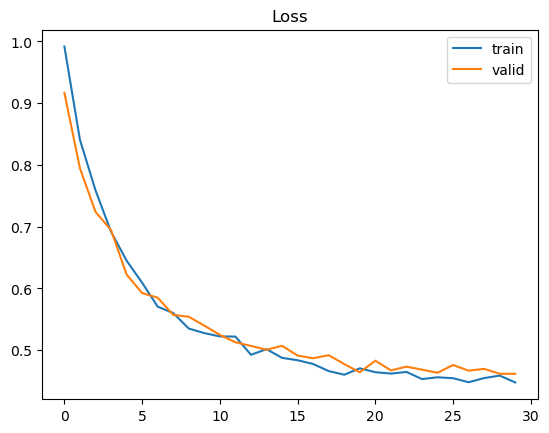

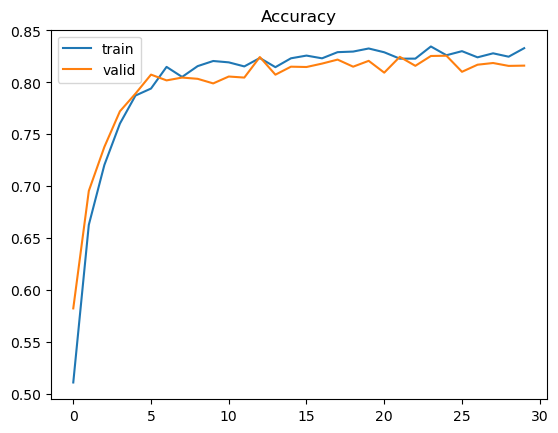

In [14]:
import sys

model.train()
losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []

for epoch in range(NUM_EPOCHS):
    losses_epoch_train = []
    losses_epoch_test = []
    acc_epoch_test = []
    acc_epoch_train = []
    for x, cat_x, labels in train_data_loader:
        predictions = model(x, cat_x).squeeze(dim=1)
        loss = loss_fn(predictions, labels.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses_epoch_train.append(loss.item())
        acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
        acc_epoch_train.append(acc)
        
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))

    with torch.no_grad():
        for x, cat_x, labels in test_data_loader:
            predictions = model(x, cat_x).squeeze(dim=1)
            loss = loss_fn(predictions, labels.long())
            losses_epoch_test.append(loss.item())
            acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
            acc_epoch_test.append(acc)
        losses_test.append(np.mean(losses_epoch_test))
        acc_test.append(np.mean(acc_epoch_test))

    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss valid: {losses_epoch_test[-1]:.3}")


plt.figure()
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])

In [15]:
model.eval()

true_predictions, num_predictions = 0., 0.
true_predictions_cheap = 0.
true_predictions_expensive = 0.
true_predictions_average = 0.


with torch.no_grad():
        predictions = model(test_dataset[:][0], test_dataset[:][1])
        labels = test_dataset[:][2]
        prediction_labels = torch.max(predictions.data, 1).indices
        true_predictions += (prediction_labels == labels).sum()
        true_predictions_cheap += (torch.logical_and(prediction_labels == labels, prediction_labels == 0)).sum()
        true_predictions_average += (torch.logical_and(prediction_labels == labels, prediction_labels == 1)).sum()
        true_predictions_expensive += (torch.logical_and(prediction_labels == labels, prediction_labels == 2)).sum()
        num_predictions += labels.shape[0]
acc = true_predictions / num_predictions
acc_cheap = true_predictions_cheap / (labels == 0).sum()
acc_average = true_predictions_average / (labels == 1).sum()
acc_expensive = true_predictions_expensive / (labels == 2).sum()

print(f"Accuracy of the model: {100.0*acc:4.2f}%")
print(f"Cheap Accuracy of the model: {100.0*acc_cheap:4.2f}%")
print(f"Average Accuracy of the model: {100.0*acc_average:4.2f}%")
print(f"Expensive Accuracy of the model: {100.0*acc_expensive:4.2f}%")

print(f"Mean accuracy { (acc_expensive+acc_average+acc_cheap) / 3}")

Accuracy of the model: 83.87%
Cheap Accuracy of the model: 92.76%
Average Accuracy of the model: 82.70%
Expensive Accuracy of the model: 80.58%
Mean accuracy 0.8534619212150574


# Accuracy on test data

In [16]:
new_data = pd.read_csv("test_data.csv")
df = pd.read_csv("train_data.csv")

In [17]:
class_nr = 0
for i in range(df['YearBuilt'].min(), df['YearBuilt'].max(), 5):
    new_data["YearBuilt"].mask( (new_data['YearBuilt']>=i) & (new_data['YearBuilt'] < i+5), class_nr, inplace=True)
    class_nr += 1

In [18]:
categorical_columns = [
    'YearBuilt', 'HallwayType', 'HeatingType',
    'AptManageType', 'TimeToBusStop', 'TimeToSubway', 'SubwayStation',
]
categorical_values = pd.get_dummies(new_data[categorical_columns].astype(str))
new_data.drop(columns=categorical_columns, inplace=True)
categorical_values.head()

,YearBuilt_0,YearBuilt_1,YearBuilt_2,YearBuilt_3,YearBuilt_5,YearBuilt_6,YearBuilt_7,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [19]:
categorical_data = categorical_values.values
numerical_data = new_data.values
print(categorical_data.shape)
print(numerical_data.shape)

(1767, 30)
(1767, 9)


In [20]:
numerical_data = ss.transform(numerical_data)
print(numerical_data)

[[-0.12542233 -0.27504087  1.52970182 ... -0.78244015  1.19933985
   1.38150964]
 [-0.14357633  0.51372651 -0.48659148 ...  1.33842446  1.19933985
   1.38150964]
 [ 1.72888006 -0.66942456 -0.8730865  ... -0.35826723 -0.24174561
  -1.33128899]
 ...
 [-0.8256484   1.03957142  1.52970182 ... -0.78244015  1.19933985
   1.38150964]
 [-0.12542233 -0.14357964  0.01166113 ...  0.91425154 -0.81817979
  -0.42702278]
 [-0.12542233 -0.4065021   1.52970182 ... -0.78244015  1.19933985
   1.38150964]]


In [21]:
numerical_data = torch.from_numpy(numerical_data).float()
categorical_data = torch.from_numpy(categorical_data).float()
print(numerical_data)
print(categorical_data)
print(numerical_data.shape)
print(categorical_data.shape)

tensor([[-0.1254, -0.2750,  1.5297,  ..., -0.7824,  1.1993,  1.3815],
        [-0.1436,  0.5137, -0.4866,  ...,  1.3384,  1.1993,  1.3815],
        [ 1.7289, -0.6694, -0.8731,  ..., -0.3583, -0.2417, -1.3313],
        ...,
        [-0.8256,  1.0396,  1.5297,  ..., -0.7824,  1.1993,  1.3815],
        [-0.1254, -0.1436,  0.0117,  ...,  0.9143, -0.8182, -0.4270],
        [-0.1254, -0.4065,  1.5297,  ..., -0.7824,  1.1993,  1.3815]])
tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
torch.Size([1767, 9])
torch.Size([1767, 30])


In [22]:
new_data_dataset = data.TensorDataset(numerical_data, categorical_data)

In [23]:
with torch.no_grad():
        predictions = model(new_data_dataset[:][0], new_data_dataset[:][1])

In [24]:
predictions

tensor([[-0.7303,  1.5322, -1.0592],
        [-1.3857,  0.6293,  0.2737],
        [-2.0423, -0.3613,  1.1945],
        ...,
        [ 0.6493,  0.6500, -1.4529],
        [-1.4744,  1.8958, -0.6973],
        [-0.7156,  1.5167, -1.0621]])

In [25]:
predictions = predictions.argmax(dim=1)
predictions

tensor([1, 1, 2,  ..., 1, 1, 1])

In [26]:
pd.DataFrame(predictions.numpy()).to_csv("predictions.csv")